In [1]:
## Kütüphane Importları

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

In [2]:
df = pd.read_csv("/content/jena_climate_2009_2016.csv")

In [3]:
## Veri Analizi

def check_df(df, head=5):
    print("### Shape ###"); print(df.shape)
    print("\n### Types ###"); print(df.dtypes)
    print(f"\n### Head ({head}) ###"); print(df.head(head))
    print(f"\n### Tail ({head}) ###"); print(df.tail(head))
    print("\n### Missing Values ###"); print(df.isnull().sum())
    print(f"\nAny Missing? {df.isnull().any().any()}")
    print(f"\nDuplicate Rows: {df.duplicated().sum()}")
    print("\n### Quantiles ###"); print(df.describe([0, 0.5, 0.95, 0.99, 1]).T)

check_df(df)

### Shape ###
(420551, 15)

### Types ###
Date Time           object
p (mbar)           float64
T (degC)           float64
Tpot (K)           float64
Tdew (degC)        float64
rh (%)             float64
VPmax (mbar)       float64
VPact (mbar)       float64
VPdef (mbar)       float64
sh (g/kg)          float64
H2OC (mmol/mol)    float64
rho (g/m**3)       float64
wv (m/s)           float64
max. wv (m/s)      float64
wd (deg)           float64
dtype: object

### Head (5) ###
             Date Time  p (mbar)  T (degC)  Tpot (K)  Tdew (degC)  rh (%)  \
0  01.01.2009 00:10:00    996.52     -8.02    265.40        -8.90    93.3   
1  01.01.2009 00:20:00    996.57     -8.41    265.01        -9.28    93.4   
2  01.01.2009 00:30:00    996.53     -8.51    264.91        -9.31    93.9   
3  01.01.2009 00:40:00    996.51     -8.31    265.12        -9.07    94.2   
4  01.01.2009 00:50:00    996.51     -8.27    265.15        -9.04    94.1   

   VPmax (mbar)  VPact (mbar)  VPdef (mbar)  sh (g/kg)  H2

In [10]:
## Tarih/Süre Formatının Dönüştürülmesi ve Index Ayarı

df["Date Time"] = pd.to_datetime(df["Date Time"], format="%d.%m.%Y %H:%M:%S")
df.set_index("Date Time", inplace=True)


In [11]:
df[:26]

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
Date Time,,,,,,,,,,,,,,
2009-01-01 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
2009-01-01 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2009-01-01 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
2009-01-01 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
2009-01-01 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3
2009-01-01 01:00:00,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
2009-01-01 01:10:00,996.50,-7.62,265.81,-8.30,94.8,3.44,3.26,0.18,2.04,3.27,1305.68,0.18,0.63,166.5
2009-01-01 01:20:00,996.50,-7.62,265.81,-8.36,94.4,3.44,3.25,0.19,2.03,3.26,1305.69,0.19,0.50,118.6
2009-01-01 01:30:00,996.50,-7.91,265.52,-8.73,93.8,3.36,3.15,0.21,1.97,3.16,1307.17,0.28,0.75,188.5


<Axes: xlabel='Date Time'>

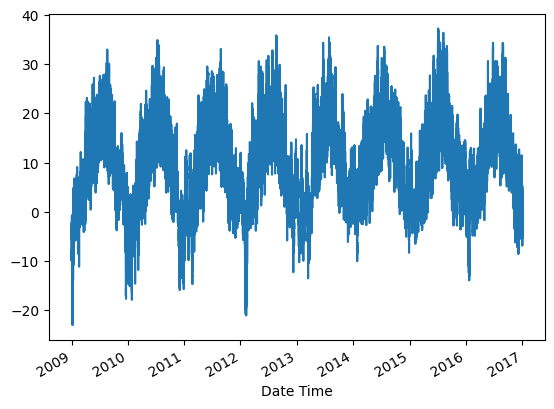

In [5]:
## Sıcaklığın Görselleştirilmesi

temp = df["T (degC)"]
temp.plot()

In [6]:
## Verilerin Window Size ile Ayarlanması

def df_to_X_y(df,window_size=5):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [[a] for a in df_as_np[i:i+5]]
    X.append(row)
    label = df_as_np[i+5]
    y.append(label)
  return np.array(X), np.array(y)

In [7]:
## Wındow Size ile Verilerin Oluşturulması

WINDOW_SIZE = 5
X,y = df_to_X_y(temp,WINDOW_SIZE)
X.shape, y.shape

((420546, 5, 1), (420546,))

In [8]:
X

array([[[-8.02],
        [-8.41],
        [-8.51],
        [-8.31],
        [-8.27]],

       [[-8.41],
        [-8.51],
        [-8.31],
        [-8.27],
        [-8.05]],

       [[-8.51],
        [-8.31],
        [-8.27],
        [-8.05],
        [-7.62]],

       ...,

       [[-4.09],
        [-3.76],
        [-3.93],
        [-4.05],
        [-3.35]],

       [[-3.76],
        [-3.93],
        [-4.05],
        [-3.35],
        [-3.16]],

       [[-3.93],
        [-4.05],
        [-3.35],
        [-3.16],
        [-4.23]]])

In [9]:
y

array([-8.05, -7.62, -7.62, ..., -3.16, -4.23, -4.82])

In [12]:
## Veri Setinin Bölünmesi

train_size = int(len(X) * 0.85)
val_size = int(len(X) * 0.10)

X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:train_size+val_size], y[train_size:train_size+val_size]
X_test, y_test = X[train_size+val_size:], y[train_size+val_size:]

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)


(357464, 5, 1) (357464,)
(42054, 5, 1) (42054,)
(21028, 5, 1) (21028,)


In [16]:
## LSTM Modelinin Oluşturulması

model1 = Sequential()
model1.add(InputLayer((5,1)))
model1.add(LSTM(64))
model1.add(Dense(8,"relu"))
model1.add(Dense(1,"linear"))

model1.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,425 (68.07 KB)

 Trainable params: 17,425 (68.07 KB)

 Non-trainable params: 0 (0.00 B)

In [23]:
## Modeli Kaydetmek,CallBack Ayarlaması

cp = ModelCheckpoint("model1.keras", save_best_only=True)
model1.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])


In [24]:
## Model Eğitimi

model1.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, callbacks=[cp])

Epoch 1/10
11171/11171 ━━━━━━━━━━━━━━━━━━━━ 41s 4ms/step - loss: 21.7829 - root_mean_squared_error: 4.1322 - val_loss: 0.0494 - val_root_mean_squared_error: 0.2224
Epoch 2/10
11171/11171 ━━━━━━━━━━━━━━━━━━━━ 40s 4ms/step - loss: 0.0510 - root_mean_squared_error: 0.2258 - val_loss: 0.0458 - val_root_mean_squared_error: 0.2140
Epoch 3/10
11171/11171 ━━━━━━━━━━━━━━━━━━━━ 41s 4ms/step - loss: 0.0460 - root_mean_squared_error: 0.2145 - val_loss: 0.0444 - val_root_mean_squared_error: 0.2106
Epoch 4/10
11171/11171 ━━━━━━━━━━━━━━━━━━━━ 43s 4ms/step - loss: 0.0450 - root_mean_squared_error: 0.2121 - val_loss: 0.0421 - val_root_mean_squared_error: 0.2051
Epoch 5/10
11171/11171 ━━━━━━━━━━━━━━━━━━━━ 42s 4ms/step - loss: 0.0444 - root_mean_squared_error: 0.2108 - val_loss: 0.0425 - val_root_mean_squared_error: 0.2062
Epoch 6/10
11171/11171 ━━━━━━━━━━━━━━━━━━━━ 81s 4ms/step - loss: 0.0444 - root_mean_squared_error: 0.2108 - val_loss: 0.0436 - val_root_mean_squared_error: 0.2088
Epoch 7/10
11171/1117

In [25]:
train_predictions = model1.predict(X_train).flatten()
train_results = pd.DataFrame(data={"Train Predictions":train_predictions, "Actuals":y_train})
train_results.head()

11171/11171 ━━━━━━━━━━━━━━━━━━━━ 15s 1ms/step


,Train Predictions,Actuals
0,-8.312667,-8.05
1,-7.890882,-7.62
2,-7.374807,-7.62
3,-7.639531,-7.91
4,-7.975488,-8.43


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_5 (LSTM)                   │ (None, 5, 128)         │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 5, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (None, 5, 64)          │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 5, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 5, 32)          │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 5, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_8 (LSTM)                   │ (None, 8)              │         1,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 129,705 (506.66 KB)

 Trainable params: 129,705 (506.66 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
1397/1397 ━━━━━━━━━━━━━━━━━━━━ 60s 40ms/step - loss: 104.7684 - mae: 7.8202 - val_loss: 41.2440 - val_mae: 3.9274
Epoch 2/100
1397/1397 ━━━━━━━━━━━━━━━━━━━━ 85s 43ms/step - loss: 41.1084 - mae: 4.1163 - val_loss: 17.2903 - val_mae: 2.1890
Epoch 3/100
1397/1397 ━━━━━━━━━━━━━━━━━━━━ 83s 43ms/step - loss: 19.5878 - mae: 2.5933 - val_loss: 7.2931 - val_mae: 1.1820
Epoch 4/100
1397/1397 ━━━━━━━━━━━━━━━━━━━━ 79s 41ms/step - loss: 10.6818 - mae: 1.8870 - val_loss: 3.0886 - val_mae: 0.6759
Epoch 5/100
1397/1397 ━━━━━━━━━━━━━━━━━━━━ 57s 41ms/step - loss: 6.8727 - mae: 1.5689 - val_loss: 1.4603 - val_mae: 0.5980
Epoch 6/100
1397/1397 ━━━━━━━━━━━━━━━━━━━━ 80s 40ms/step - loss: 5.1170 - mae: 1.4199 - val_loss: 0.6829 - val_mae: 0.3903
Epoch 7/100
1397/1397 ━━━━━━━━━━━━━━━━━━━━ 58s 41ms/step - loss: 4.3163 - mae: 1.3414 - val_loss: 0.3101 - val_mae: 0.2541
Epoch 8/100
1397/1397 ━━━━━━━━━━━━━━━━━━━━ 81s 41ms/step - loss: 3.8639 - mae: 1.2900 - val_loss: 0.3351 - val_mae: 0.3925
Epoch 9/1

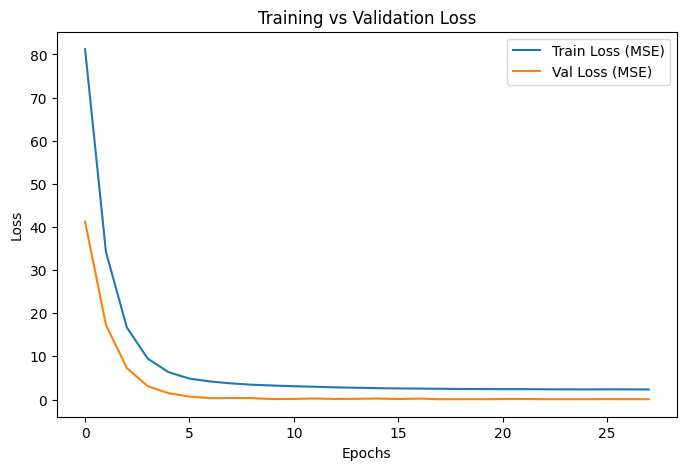

658/658 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.1103 - mae: 0.2253
Test Loss (MSE): 0.0748
Test MAE: 0.1790


In [27]:
## LSTM Model Mimarisini Tasarlamak

model = Sequential()
model.add(InputLayer((5,1)))

# LSTM katmanları
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(32, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(8))
model.add(Dropout(0.2))

# Dense çıkış
model.add(Dense(1, activation="linear"))

model.summary()

# Derleme
model.compile(
    loss="mse",
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
    metrics=["mae"]
)

# Callback'ler
early_stop = EarlyStopping(
    monitor="val_loss",
    patience=10,
    restore_best_weights=True
)

checkpoint = ModelCheckpoint(
    "best_model.keras",
    save_best_only=True,
    monitor="val_loss"
)

# Eğitim
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=256,
    callbacks=[early_stop, checkpoint],
    verbose=1
)

# Loss grafiği
plt.figure(figsize=(8,5))
plt.plot(history.history["loss"], label="Train Loss (MSE)")
plt.plot(history.history["val_loss"], label="Val Loss (MSE)")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training vs Validation Loss")
plt.show()

# Test set değerlendirme
test_loss, test_mae = model.evaluate(X_test, y_test)
print(f"Test Loss (MSE): {test_loss:.4f}")
print(f"Test MAE: {test_mae:.4f}")


In [28]:
## Optimizer ve Gradyan Ayarları

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3, clipnorm=1.0)

model = Sequential([
    InputLayer((5,1)),
    LSTM(128, return_sequences=True),
    Dropout(0.2),
    LSTM(64),
    Dropout(0.2),
    Dense(32, activation="relu"),
    Dense(1, activation="linear"),
])

model.compile(loss="mse", optimizer=optimizer, metrics=["mae", RootMeanSquaredError()])

early_stop = EarlyStopping(monitor="val_loss", patience=8, restore_best_weights=True)
rlrop = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6)
ckpt = ModelCheckpoint("best_model.keras", save_best_only=True, monitor="val_loss")

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=512,
    callbacks=[early_stop, rlrop, ckpt],
    shuffle=False,
    verbose=1
)


Epoch 1/100
699/699 ━━━━━━━━━━━━━━━━━━━━ 41s 54ms/step - loss: 23.8427 - mae: 3.1617 - root_mean_squared_error: 4.7515 - val_loss: 0.1120 - val_mae: 0.2371 - val_root_mean_squared_error: 0.3347 - learning_rate: 0.0010
Epoch 2/100
699/699 ━━━━━━━━━━━━━━━━━━━━ 37s 54ms/step - loss: 0.9302 - mae: 0.6642 - root_mean_squared_error: 0.9618 - val_loss: 0.1691 - val_mae: 0.3084 - val_root_mean_squared_error: 0.4112 - learning_rate: 0.0010
Epoch 3/100
699/699 ━━━━━━━━━━━━━━━━━━━━ 43s 56ms/step - loss: 0.8154 - mae: 0.6222 - root_mean_squared_error: 0.9010 - val_loss: 0.2037 - val_mae: 0.3525 - val_root_mean_squared_error: 0.4513 - learning_rate: 0.0010
Epoch 4/100
699/699 ━━━━━━━━━━━━━━━━━━━━ 41s 56ms/step - loss: 0.7914 - mae: 0.6017 - root_mean_squared_error: 0.8873 - val_loss: 0.3155 - val_mae: 0.4503 - val_root_mean_squared_error: 0.5617 - learning_rate: 0.0010
Epoch 5/100
699/699 ━━━━━━━━━━━━━━━━━━━━ 38s 54ms/step - loss: 0.5775 - mae: 0.5142 - root_mean_squared_error: 0.7581 - val_loss: 0

658/658 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0498 - mae: 0.1543 - root_mean_squared_error: 0.2224
Test Loss (MSE): 0.0420
Test MAE: 0.1375
Test RMSE: 0.2049
658/658 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


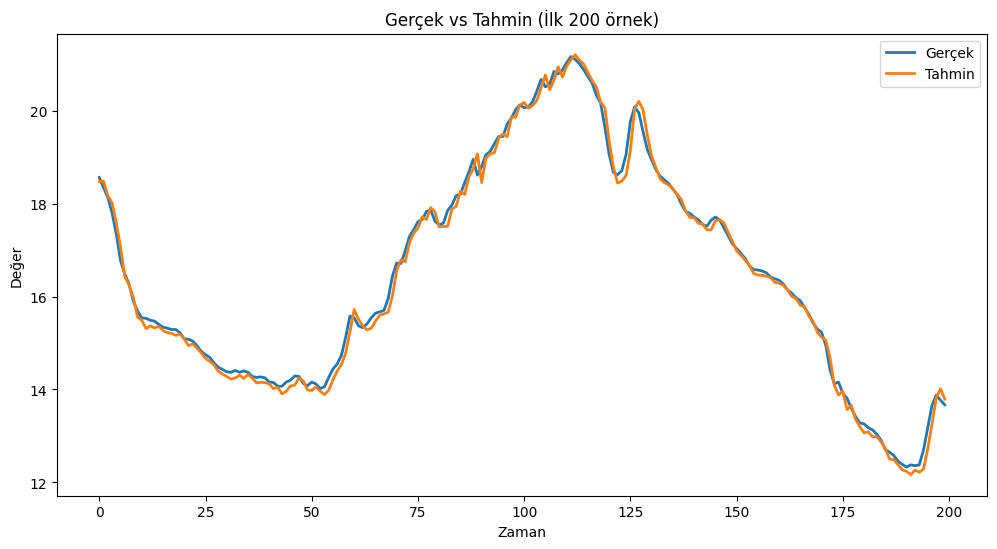

In [29]:
## Test seti değerlendirme
test_loss, test_mae, test_rmse = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss (MSE): {test_loss:.4f}")
print(f"Test MAE: {test_mae:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")

# Tahmin
y_pred = model.predict(X_test)


y_pred = y_pred.flatten()
y_true = y_test.flatten()

# İlk 200 örnek için görselleştirme
plt.figure(figsize=(12,6))
plt.plot(y_true[:200], label="Gerçek", linewidth=2)
plt.plot(y_pred[:200], label="Tahmin", linewidth=2)
plt.title("Gerçek vs Tahmin (İlk 200 örnek)")
plt.xlabel("Zaman")
plt.ylabel("Değer")
plt.legend()
plt.show()


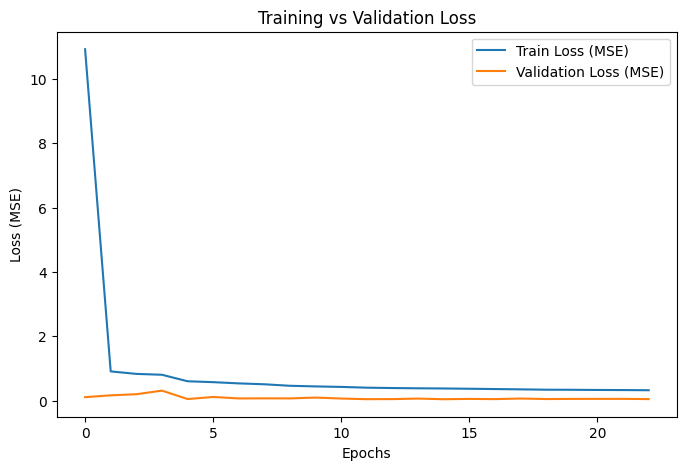

In [31]:
## Eğitim ve doğrulama loss grafiği
plt.figure(figsize=(8,5))
plt.plot(history.history["loss"], label="Train Loss (MSE)")
plt.plot(history.history["val_loss"], label="Validation Loss (MSE)")
plt.xlabel("Epochs")
plt.ylabel("Loss (MSE)")
plt.title("Training vs Validation Loss")
plt.legend()
plt.show()


In [32]:
# DataFrame ile karşılaştırma tablosu
comparison_df = pd.DataFrame({
    "Predictions": y_pred[:20],   # ilk 20 örnek
    "Actuals": y_true[:20]
})

print(comparison_df.head())

# Daha şık görüntü için
from IPython.display import display
display(comparison_df.head(20))


   Predictions  Actuals
0    18.473518    18.56
1    18.484364    18.34
2    18.167734    18.13
3    18.015261    17.80
4    17.585772    17.34


,Predictions,Actuals
0,18.473518,18.56
1,18.484364,18.34
2,18.167734,18.13
3,18.015261,17.80
4,17.585772,17.34
5,17.060463,16.77
6,16.430239,16.48
7,16.246010,16.27
8,15.983110,15.90
9,15.560740,15.69


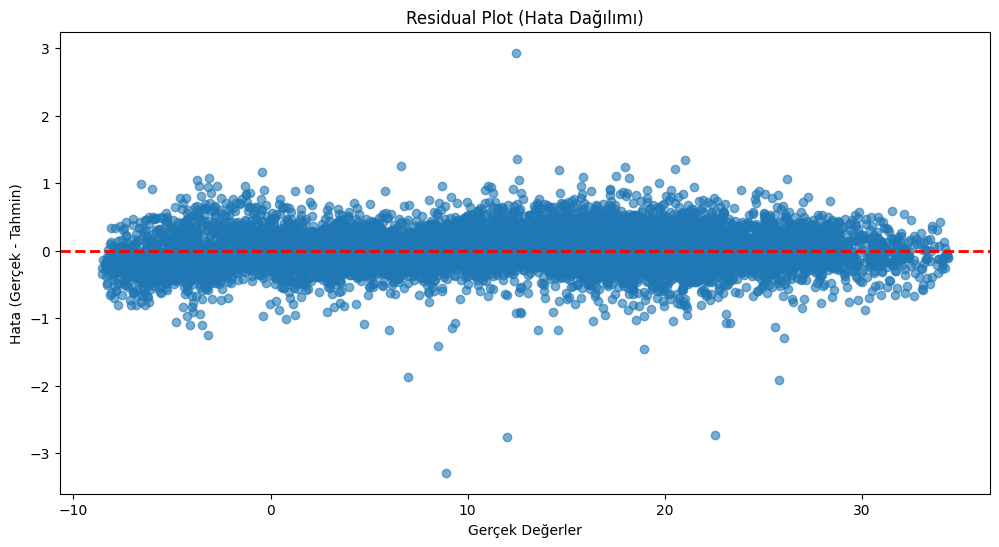

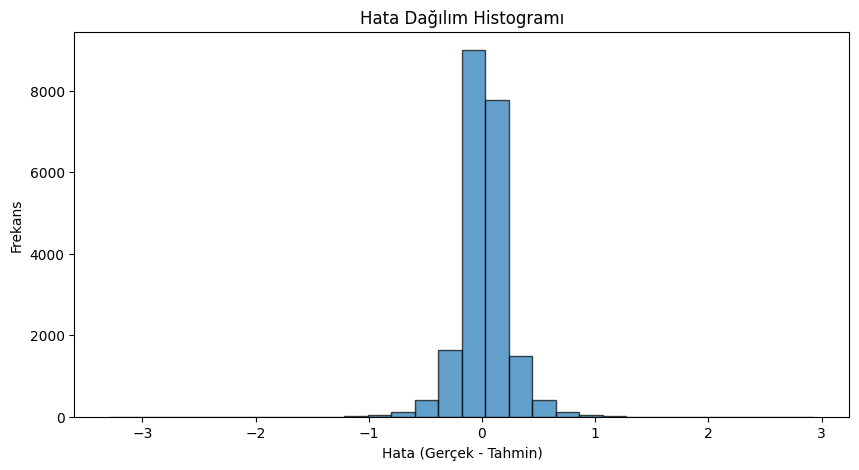

In [33]:


# Kalıntılar
residuals = y_true - y_pred

plt.figure(figsize=(12,6))
plt.scatter(y_true, residuals, alpha=0.6)
plt.axhline(0, color="red", linestyle="--", linewidth=2)
plt.xlabel("Gerçek Değerler")
plt.ylabel("Hata (Gerçek - Tahmin)")
plt.title("Residual Plot (Hata Dağılımı)")
plt.show()


plt.figure(figsize=(10,5))
plt.hist(residuals, bins=30, edgecolor="k", alpha=0.7)
plt.title("Hata Dağılım Histogramı")
plt.xlabel("Hata (Gerçek - Tahmin)")
plt.ylabel("Frekans")
plt.show()
